In [1]:
from collections import Counter
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
# # Раскомментируйте и скачайте эмбеддинги
# !wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
# !gzip -d cc.en.300.vec.gz

In [3]:
def load_embeddings(path, num_tokens=None, special_tokens=["<PAD>", "<UNK>"], verbose=True):
    """
    Get mapping between token and its id in vocabulary and embeddings matrix
    path: str
    num_tokens: maximum number of vocabular (None if no truncation apply)
    
    return: token2index dictionaty, embeddigts matrix (np.array of shape  (num_tokens, emb_dim))
    """
    
    with open(path) as f:
        num_words, emb_dim = f.readline().strip().split()
        num_words, emb_dim = int(num_words), int(emb_dim)
        
        # Create initial matrix with padding token and unknown
        token2index: Dict[str, int] = {token: idx for idx, token in enumerate(special_tokens)}
        embeddings_matrix: np.array = np.random.rand(len(token2index), emb_dim)
        print(f"Created embedding matrix with shape {embeddings_matrix.shape}")

        # Specify maximum number of tokens if not setted
        if num_tokens is None:
            num_tokens = num_words + len(token2index)

        progress_bar = tqdm(total=num_tokens-len(token2index), disable=not verbose, desc='Reading embeddings file')
        for line in f:
            parts = line.strip().split()
            token = ' '.join(parts[:-emb_dim]).lower()
            if token in token2index:
                continue
            word_vector = np.array(list(map(float, parts[-emb_dim:]))).reshape(1, -1)
            token2index[token] = len(token2index)
            embeddings_matrix = np.append(embeddings_matrix, word_vector, axis=0)
            progress_bar.update()
            if len(token2index) == num_tokens:
                break

        progress_bar.close()
        assert(len(token2index) == embeddings_matrix.shape[0])

    return token2index, embeddings_matrix

In [4]:
token2index, embeddings_matrix = load_embeddings(
    path="cc.en.300.vec",
    num_tokens=50_000
)

Created embedding matrix with shape (2, 300)


Reading embeddings file: 100%|██████████| 49998/49998 [43:47<00:00, 19.03it/s]


## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [5]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/home/jovyan/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [6]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [7]:
for batch in train_loader:
    break

batch

{'text': ['@user on Sunday in Milan it\'s Derby Day! I\'m re-wearching that video about it, Sick. #Amala #forzaInter"',
  'Do the Black Friday verses from Kendrick and Cole count?'],
 'label': tensor([2, 1])}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [8]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [9]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [10]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [11]:
def empty_collate(batch):
    return batch

In [12]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [13]:
for batch in train_loader:
    break

batch

[{'text': '"The 2013 San Diego County Fair theme will be """"Game On,"""" all about board, pinball, TV and computer games. Begins June 8. #sdfair"',
  'label': 1},
 {'text': '"\\""""Ghost of Mississippi\\"""" The story of the ghost that tripped Eli Manning on 4th down that fateful autumn night in Oxford. #30for30"',
  'label': 1}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [14]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        token_ids = []
        for token in tokenized_text:
            token_id = token2index.get(token, self.unk_index)
            token_ids.append(token_id)
        return token_ids
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        # TODO remove repeating unk indices.
        
        if len(tokens_indices) > self.max_length:
            return tokens_indices[:self.max_length]
        
        pad_ids = [self.pad_index] * (self.max_length - len(tokens_indices))
        tokens_indices.extend(pad_ids)
        return tokens_indices
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        text_tokenized = self.tokenize(text)
        text_indexed = self.indexing(text_tokenized)
        text_padded = self.padding(text_indexed)
        return text_padded
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            label = sample["label"]
            text = sample["text"]
            
            text_processed = self(text)
            
            tokenized_texts.append(text_processed)
            labels.append(label)
            
        tokenized_texts = torch.tensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.tensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

In [15]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=token2index,
    pad_token="<PAD>",
    unk_token="<UNK>",
    max_length=25
)

In [16]:
text = batch[0]["text"]
print(tokenizer(text))

[17, 1, 208, 1, 1, 1, 1, 1798, 45, 29, 17, 17, 17, 17, 1, 1, 2, 17, 17, 17, 17, 49, 56, 874, 2]


## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [17]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)

In [18]:
for x, y in train_loader:
    pass

In [19]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

In [20]:
# Посмотрим на распределение классов по всей выборке. 

train_labels = pd.Series([x["label"] for x in train_dataset])
valid_labels = pd.Series([x["label"] for x in valid_dataset])
test_labels = pd.Series([x["label"] for x in test_dataset])

In [21]:
id2label = {0: "negative", 1: "neutral", 2:"positive"}

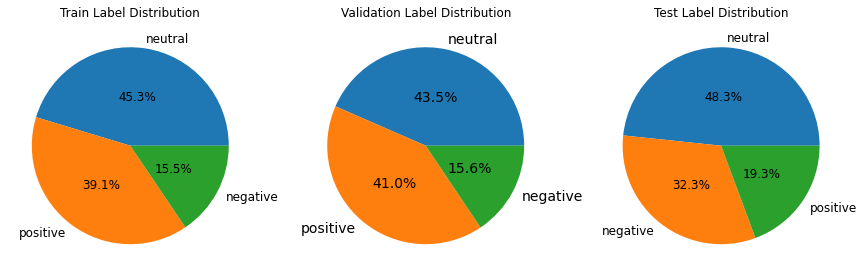

In [22]:

fig, axs = plt.subplots(1, 3, figsize=(15,15))

axs[0].pie(
    train_labels.value_counts(),
    autopct="%.1f%%", 
    labels=[id2label[key] for key in train_labels.value_counts().keys()], 
    pctdistance=0.5, 
    textprops = dict(fontsize = 12),
)
axs[0].set_title("Train Label Distribution")

axs[1].pie(
    valid_labels.value_counts(),
    autopct="%.1f%%", 
    labels=[id2label[key] for key in valid_labels.value_counts().keys()], 
    pctdistance=0.5, 
    textprops = dict(fontsize = 14)
)
axs[1].set_title("Validation Label Distribution")

axs[2].pie(
    test_labels.value_counts(),
    autopct="%.1f%%", 
    labels=[id2label[key] for key in test_labels.value_counts().keys()], 
    pctdistance=0.5, 
    textprops = dict(fontsize = 12)
)
axs[2].set_title("Test Label Distribution")

plt.show()

# Я выбрала метрику F1-Score (weighted)

Если мы посмтрим на распледеление таргета на рисунках выше, то увидим, что у нас несбалансированный датасет (самый малочисленный класс - 0). Поэтому базовая метрика для классификации Accuracy нам здесь может показать нерелевантное качество на класссе 0 (модели может быть выгодно чаще выбирать лейбл других классов, чем этот => будет страдать Recall для класса 0 и Precision для остальных классов). 

Так как мы считаем, что все классы для нас одинаково важны, то нужно соблюзти баланс в качестве относительно каждого класса. Это и позволяет сделать метрика F1-weighted. Она считает F1-score для каждого класса и возвращает средний F1-score в соответствии с пропорциями классов => 1)будет учтен дисбаланс классов 2)Для каждого класса будут сбалансированы Precision и Recall



In [23]:
class DeepAverageNetwork(nn.Module):
    def __init__(self,
        vocab_size=10000,
        embedding_dim=300,
        do_freeze_embeddings=False,
        padding_idx=0,
        embeddings=None,
        pooling="mean",
        hidden_size=128,
        num_classes=3,
    ):       
        super(DeepAverageNetwork, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        if embeddings is not None:
            self.embeddings.from_pretrained(
                torch.tensor(embeddings),
                freeze=do_freeze_embeddings,
                padding_idx=padding_idx
            )
        
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

        if pooling == "mean":
            self.pooling = torch.mean
        else:
            print(f"Unsuppoted Pulling Type {pooling}. Switch pooling to default mean type")
        
    
    def forward(self, x: torch.Tensor): # (batch_size, max_seq_length)
        
        x = self.embeddings(x) # (batch_size, max_seq_length, embedding_dim)
        x = self.pooling(x, dim=1) # (batch_size, embedding_dim)
        x = self.fc1(x) # (batch_size, hidden_size)
        x = self.relu(x)
        x = self.fc2(x) # (batch_size, num_classes)
        
        return x

In [24]:
model = DeepAverageNetwork(
    vocab_size=embeddings_matrix.shape[0],
    embedding_dim=embeddings_matrix.shape[-1],
    do_freeze_embeddings=False,
    padding_idx=tokenizer.pad_index,
    embeddings=embeddings_matrix,
    pooling="mean",
    hidden_size=128,
    num_classes=3,
)

In [25]:
model

DeepAverageNetwork(
  (embeddings): Embedding(50000, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

## Задайте функцию потерь и оптимизатор

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3) #1e-3 был выбран дефолтным значением

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model.to(device)
criterion.to(device)

CrossEntropyLoss()

## Сделайте цикл обучения

In [27]:
def train(model, iterator, criterion, optimizer):
    
    losses = []
    y_trues = []
    y_preds = []
    
    
    pbar = tqdm(enumerate(iterator), total=len(iterator), desc="Training")
    for _, batch in pbar:
        text, y_true = batch[0], batch[1]
        optimizer.zero_grad()   
        y_pred = model(text.to(device)).squeeze() 
        loss = criterion(y_pred, y_true.to(device))   
        
        
        loss.backward()
        optimizer.step()
        
        y_pred = torch.argmax(y_pred, dim=1).tolist()
        y_trues.extend(y_true.tolist())
        y_preds.extend(y_pred)
        
        losses.append(loss.item())
        
        pbar.set_postfix({'loss': loss.item()})
    
    f1_score_epoch = f1_score(y_trues, y_preds, average="weighted")
    
    return losses, f1_score_epoch

In [28]:
def evaluate(model, iterator, criterion, show_classification_report=False):
    
    losses = []
    y_trues = []
    y_preds = []
    
    
    pbar = tqdm(enumerate(iterator), total=len(iterator), desc="Evaluation")
    with torch.no_grad():
        for _, batch in pbar:
            text, y_true = batch[0], batch[1]
            y_pred = model(text.to(device)).squeeze() 
            
            loss = criterion(y_pred, y_true.to(device))   
            losses.append(loss.item())
            
            y_pred = torch.argmax(y_pred, dim=1).tolist()
            y_trues.extend(y_true.tolist())
            y_preds.extend(y_pred)


            pbar.set_postfix({'loss': loss.item()})
    
    f1_score_epoch = f1_score(y_trues, y_preds, average="weighted")
    loss = np.array(losses).mean()
    
    if show_classification_report: # For test data purposes
        print(classification_report(y_trues, y_preds))

    return losses, f1_score_epoch

In [29]:
NUM_EPOCHS = 15  # Задайте количество эпох

losses_train_total = []
losses_valid_total = []

f1_train = []
f1_eval = []

for n_epoch in range(NUM_EPOCHS):
    print(f"Epoch {n_epoch}")
    
    # training
    losses_train, f1_score_train = train(
        model=model,
        iterator=train_loader,
        criterion=criterion,
        optimizer=optimizer
    )
    
    loss_train_epoch = np.array(losses_train).mean()   
    f1_train.append(f1_score_train)
    losses_train_total.append(loss_train_epoch)
    
    
    # validation
    losses_valid, f1_score_valid = evaluate(
        model=model,
        iterator=valid_loader,
        criterion=criterion,
    )
    
    loss_valid_epoch = np.array(losses_valid).mean()   
    f1_eval.append(f1_score_valid)
    losses_valid_total.append(loss_valid_epoch)
    
    print(f"Train loss: {loss_train_epoch}, Train F1-score: {f1_score_train}\nValidation loss: {loss_valid_epoch} Validation F1-score: {f1_score_valid}\n")

Epoch 0


Evaluation: 100%|██████████| 8/8 [00:00<00:00,  8.83it/s, loss=0.874]


Train loss: 0.9607333967139601, Train F1-score: 0.47963476150973433
Validation loss: 0.9345271438360214 Validation F1-score: 0.5045110254711

Epoch 1


Evaluation: 100%|██████████| 8/8 [00:00<00:00, 10.12it/s, loss=0.888]


Train loss: 0.8809857501663976, Train F1-score: 0.5564559592260009
Validation loss: 0.8926337510347366 Validation F1-score: 0.5612657557045693

Epoch 2


Evaluation: 100%|██████████| 8/8 [00:00<00:00,  9.95it/s, loss=0.869]


Train loss: 0.8181865231950856, Train F1-score: 0.6064864650318065
Validation loss: 0.8743023350834846 Validation F1-score: 0.5688730042490326

Epoch 3


Evaluation: 100%|██████████| 8/8 [00:00<00:00, 10.23it/s, loss=0.777]


Train loss: 0.7668965388942697, Train F1-score: 0.6433208660680741
Validation loss: 0.8613495752215385 Validation F1-score: 0.594316164425103

Epoch 4


Evaluation: 100%|██████████| 8/8 [00:00<00:00,  8.91it/s, loss=0.9]  


Train loss: 0.719515492796232, Train F1-score: 0.6749220716512654
Validation loss: 0.8588440492749214 Validation F1-score: 0.6098519496572248

Epoch 5


Evaluation: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s, loss=0.885]


Train loss: 0.6810815187805858, Train F1-score: 0.6962752171294846
Validation loss: 0.8678638935089111 Validation F1-score: 0.6075137655815622

Epoch 6


Training:   6%|▌         | 11/179 [00:12<03:04,  1.10s/it, loss=0.686]


KeyboardInterrupt: 

In [ ]:
# Остановила обучение, так как лосс на валидации начал возрастать

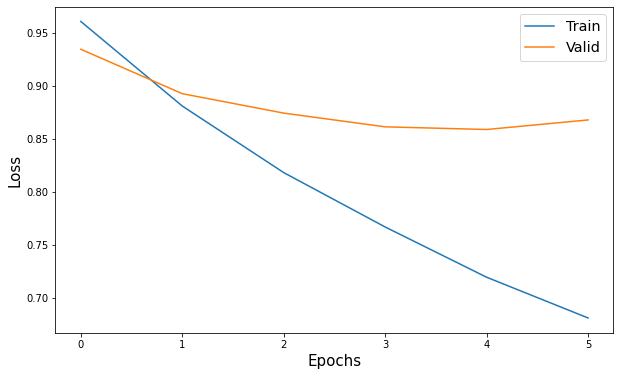

In [30]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(losses_train_total)), losses_train_total, label='Train')
plt.plot(np.arange(len(losses_valid_total)), losses_valid_total, label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

In [31]:
# Test Model on Hold Out Test Data
_, f1_score_test = evaluate(model=model, iterator=test_loader, criterion=criterion, show_classification_report=True)

Evaluation: 100%|██████████| 48/48 [00:05<00:00,  9.04it/s, loss=1.01] 


              precision    recall  f1-score   support

           0       0.65      0.33      0.44      3972
           1       0.58      0.77      0.66      5937
           2       0.49      0.49      0.49      2375

    accuracy                           0.57     12284
   macro avg       0.57      0.53      0.53     12284
weighted avg       0.59      0.57      0.56     12284



# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

В ходе работы над заданием удалось реализовать простейшую архитектуру (усреднение эмбеддингов + вектора слов). Ее можно считать бейзлайном 2 уровня (после tfidf+logreg). 

Но и в этой модели есть несколько путей для улучшения: 
* Подбор оптимальных эмбеддингов (сейчас взяты без какого-либо глубокого анализа)
* Реализация не только усреднения эмбеддингов, но и min/max пулинга
* Подбор оптимальных гиперпараметров (hidden_size, learning_rate)
* Отлов момента переобучения (через early-stoppinh)

Тем не менее, модель уже выдает приемлимое качество и ее архитектуру можно использовать и докручивать для других задач.